<a href="https://colab.research.google.com/github/jeonghojo00/ImageCaptioning/blob/main/ImgCaptioning_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing
Before running training, images and captions are needed to be preprocessed.
1. Captions ared needed to be changed to lowercase and tokenized </br>
   1.1. These captions are also used for making a vocabulary dicitonary for caption generations </br>
2. Images are needed to be loaded, changed to RGB array, calculated for means and standard deviation, then normalized.  </br>

## DataLoading

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change directory to the package folder
%cd '/content/drive/MyDrive/Colab Notebooks/ImageCaptioning/'
# Verify the contents of the current folder
!ls

/content/drive/MyDrive/Colab Notebooks/ImageCaptioning
checkpoint	      show_attend_tell.py    train-model-12300.pkl
code		      train-model-11000.pkl  train-model-12400.pkl
cs7643-final-project  train-model-1100.pkl   train-model-12500.pkl
data		      train-model-11100.pkl  train-model-12600.pkl
data_loader.py	      train-model-11200.pkl  train-model-1300.pkl
efficientnet.py       train-model-11300.pkl  train-model-1400.pkl
experiments	      train-model-11400.pkl  train-model-1500.pkl
inception.py	      train-model-11500.pkl  train-model-1600.pkl
load_data.py	      train-model-11600.pkl  train-model-1700.pkl
lstm_decoder.py       train-model-11700.pkl  train-model-1800.pkl
main.py		      train-model-11800.pkl  train-model-1900.pkl
models		      train-model-11900.pkl  utils.py
models.py	      train-model-12000.pkl  vgg.py
pretraining.py	      train-model-1200.pkl   vocab.pkl
__pycache__	      train-model-12100.pkl  vocabulary.py
resnet.py	      train-model-12200.pkl


In [3]:
import os
import pandas as pd


### Read caption file and clean the captions

In [4]:
# read_caption function
data_loc = "./data/flickr8k"
img_loc = os.path.join(data_loc, "Images")
captions_file = os.path.join(data_loc, "captions.txt")
caption = pd.read_csv(captions_file, sep = ',' if 'txt' in captions_file else '|')
print("Imported captions.txt")
print(caption.head())
cols = list(caption.columns)
img_id_col = cols[0]
caption['cleaned_caption'] = caption[cols[-1]].apply(lambda caption : ' '.join([word.lower() if word.isalpha() else '' for word in caption.split(" ")]))
print("\nCaptions after cleaning")
print(caption.head())


Imported captions.txt
                       image                                            caption
0  1000268201_693b08cb0e.jpg  A child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg              A girl going into a wooden building .
2  1000268201_693b08cb0e.jpg   A little girl climbing into a wooden playhouse .
3  1000268201_693b08cb0e.jpg  A little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  A little girl in a pink dress going into a woo...

Captions after cleaning
                       image  ...                                    cleaned_caption
0  1000268201_693b08cb0e.jpg  ...  a child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e.jpg  ...               a girl going into a wooden building 
2  1000268201_693b08cb0e.jpg  ...    a little girl climbing into a wooden playhouse 
3  1000268201_693b08cb0e.jpg  ...  a little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e.jpg  ...  a little girl

In [5]:
import numpy as np
import torch

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

For one image multiple captions are assigned.

In [6]:
# split_caption function
random_seed = 123
validation_split = 0.2
test_split = 0.1

dataset = caption
id_col = img_id_col
print("Number of captions: ", len(dataset))
set_seed(random_seed)
img_id = dataset[id_col].drop_duplicates()

dataset_size = len(img_id)
print("Number of images. : ", dataset_size)
print(img_id)


Number of captions:  40455
Number of images. :  8091
0        1000268201_693b08cb0e.jpg
5        1001773457_577c3a7d70.jpg
10       1002674143_1b742ab4b8.jpg
15       1003163366_44323f5815.jpg
20       1007129816_e794419615.jpg
                   ...            
40430     990890291_afc72be141.jpg
40435      99171998_7cc800ceef.jpg
40440      99679241_adc853a5c0.jpg
40445     997338199_7343367d7f.jpg
40450     997722733_0cb5439472.jpg
Name: image, Length: 8091, dtype: object


In [7]:
indices = list(range(dataset_size))
split_dev = int(np.floor((1 - validation_split - test_split) * dataset_size))
print(split_dev)
split_valid = int(np.floor(validation_split * dataset_size))
print(split_valid)

# avoid rounding to 1 obs if specifying 0 split
if validation_split == 0:
    split_valid = 0
if test_split == 0 and validation_split > 0:
    split_valid = dataset_size - split_dev

train_indices, val_indices, test_indices = indices[:split_dev], indices[split_dev:(split_dev + split_valid)], indices[(split_dev + split_valid):]

5663
1618


In [8]:
# Extract image ids based on indices
train_ids = img_id.iloc[train_indices].tolist()
valid_ids = img_id.iloc[val_indices].tolist()
test_ids = img_id.iloc[test_indices].tolist()

# Make train, valid, test dataset based on image ids assigned for each type
train_dat, valid_dat, test_dat = dataset[dataset[id_col].isin(train_ids)], dataset[dataset[id_col].isin(valid_ids)], dataset[dataset[id_col].isin(test_ids)]

## Make a Vocab Dictionary

In [9]:
import spacy

spacy_eng = spacy.load("en")

class Vocabulary:
    def __init__(self, freq_threshold, verbose=True):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold
        self.verbose = verbose

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4
        total = len(sentence_list)
        for i, sentence in enumerate(sentence_list):
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
            if self.verbose and i % 1000 == 0:
                print(f"processed {i} of {total} ({round(i/total, 3)})")

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]

Make a vocabulary dictionary with captions. </br>
"freq_threshold" indicates the minimum number of occurrance of words in the sentence dataset to be included in the vocabulary dictionary to speed up the training

In [10]:
# Example of vocab dictionary
print(caption['cleaned_caption'].iloc[0:5])
vocab = Vocabulary(freq_threshold=1)
vocab.build_vocabulary(caption['cleaned_caption'].iloc[0:5].tolist())

print("\nIndex to Sentence")
print(vocab.itos)
print("\nSentence to Index")
print(vocab.stoi)

0    a child in a pink dress is climbing up a set o...
1                 a girl going into a wooden building 
2      a little girl climbing into a wooden playhouse 
3    a little girl climbing the stairs to her playh...
4    a little girl in a pink dress going into a woo...
Name: cleaned_caption, dtype: object
processed 0 of 5 (0.0)

Index to Sentence
{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'a', 5: 'child', 6: 'in', 7: 'pink', 8: 'dress', 9: 'is', 10: 'climbing', 11: 'up', 12: 'set', 13: 'of', 14: 'stairs', 15: 'an', 16: 'entry', 17: 'way', 18: 'girl', 19: 'going', 20: 'into', 21: 'wooden', 22: 'building', 23: 'little', 24: 'playhouse', 25: 'the', 26: 'to', 27: 'her', 28: 'cabin'}

Sentence to Index
{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'a': 4, 'child': 5, 'in': 6, 'pink': 7, 'dress': 8, 'is': 9, 'climbing': 10, 'up': 11, 'set': 12, 'of': 13, 'stairs': 14, 'an': 15, 'entry': 16, 'way': 17, 'girl': 18, 'going': 19, 'into': 20, 'wooden': 21, 'building': 22, 'little

In [11]:
# Make a vocab dictinoary for whole sentences
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(caption['cleaned_caption'].tolist())

processed 0 of 40455 (0.0)
processed 1000 of 40455 (0.025)
processed 2000 of 40455 (0.049)
processed 3000 of 40455 (0.074)
processed 4000 of 40455 (0.099)
processed 5000 of 40455 (0.124)
processed 6000 of 40455 (0.148)
processed 7000 of 40455 (0.173)
processed 8000 of 40455 (0.198)
processed 9000 of 40455 (0.222)
processed 10000 of 40455 (0.247)
processed 11000 of 40455 (0.272)
processed 12000 of 40455 (0.297)
processed 13000 of 40455 (0.321)
processed 14000 of 40455 (0.346)
processed 15000 of 40455 (0.371)
processed 16000 of 40455 (0.396)
processed 17000 of 40455 (0.42)
processed 18000 of 40455 (0.445)
processed 19000 of 40455 (0.47)
processed 20000 of 40455 (0.494)
processed 21000 of 40455 (0.519)
processed 22000 of 40455 (0.544)
processed 23000 of 40455 (0.569)
processed 24000 of 40455 (0.593)
processed 25000 of 40455 (0.618)
processed 26000 of 40455 (0.643)
processed 27000 of 40455 (0.667)
processed 28000 of 40455 (0.692)
processed 29000 of 40455 (0.717)
processed 30000 of 40455 (0

## Image Preprocessing

Image Shape:  (500, 375, 3)


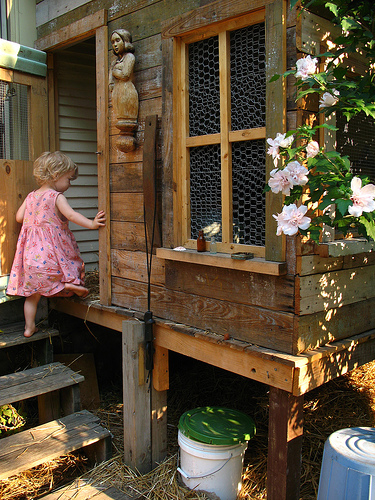

In [14]:
from PIL import Image

img_id = caption[img_id_col].iloc[0]
img = Image.open(os.path.join(img_loc, img_id)).convert('RGB')
img_np = np.array(img)
print("Image Shape: ", img_np.shape)
img


Shape of Image after transforms:  torch.Size([3, 256, 256])


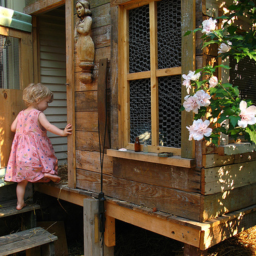

In [26]:
# Image transformation without normalization
from torchvision import transforms
import torch

# Preset mean and standard deviation
img_mean=[0.485, 0.456, 0.406]
img_std=[0.229, 0.224, 0.225]

# Image size
img_size = 256

transform = transforms.Compose([                                       
    transforms.Resize(img_size),                          # smaller edge of image resized to 256
    transforms.RandomCrop(img_size),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),
    ])

tr_img = transform(img)
print("Shape of Image after transforms: ", tr_img.shape)
to_pil = transforms.ToPILImage()
tr_image_display = to_pil(tr_img)

tr_image_display

Shape of Image after transforms:  torch.Size([3, 256, 256])


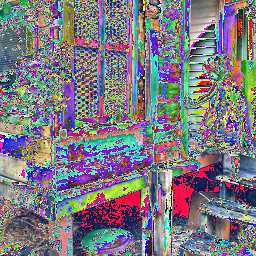

In [27]:
# Normalization added
transform = transforms.Compose([                                       
    transforms.Resize(img_size),                          # smaller edge of image resized to 256
    transforms.RandomCrop(img_size),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                         # convert the PIL Image to a tensor
    transforms.Normalize(img_mean,      # normalize image for pre-trained model
                         img_std)])

tr_img = transform(img)
print("Shape of Image after transforms: ", tr_img.shape)
to_pil = transforms.ToPILImage()
tr_image_display = to_pil(tr_img)

tr_image_display

## Captions Preprocessing

In [28]:
def process_caption_tokens(cap, max_seq_len = 40):
    numericalized_caption = [vocab.stoi["<SOS>"]]
    numericalized_caption += vocab.numericalize(cap)
    numericalized_caption.append(vocab.stoi["<EOS>"])
    pad_len = max(0, max_seq_len - len(numericalized_caption))
    if pad_len > 0:
        numericalized_caption += [vocab.stoi["<PAD>"]] * pad_len
    return numericalized_caption

In [43]:
# Tokenize a sentence

numericalized_caption = process_caption_tokens(caption['cleaned_caption'].iloc[0])
print("Cleaned Caption")
print(caption['cleaned_caption'].iloc[0])
print("\nA tokenized list of the cleaned caption")
print(numericalized_caption)

Cleaned Caption
a child in a pink dress is climbing up a set of stairs in an entry way 

A tokenized list of the cleaned caption
[1, 4, 27, 7, 4, 188, 147, 16, 31, 66, 4, 344, 10, 698, 7, 23, 3, 488, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [42]:
# Tokenized list into Sentence
ex_s = ""

for i in range(len(numericalized_caption)):
    id = numericalized_caption[i]
    if id > 2:
        word = vocab.itos[id]
        print("id: ", id, ", word: ", word)
        ex_s += word
        ex_s += " "
print(ex_s)

id:  4 , word:  a
id:  27 , word:  child
id:  7 , word:  in
id:  4 , word:  a
id:  188 , word:  pink
id:  147 , word:  dress
id:  16 , word:  is
id:  31 , word:  climbing
id:  66 , word:  up
id:  4 , word:  a
id:  344 , word:  set
id:  10 , word:  of
id:  698 , word:  stairs
id:  7 , word:  in
id:  23 , word:  an
id:  3 , word:  <UNK>
id:  488 , word:  way
a child in a pink dress is climbing up a set of stairs in an <UNK> way 
